In [1]:
import uproot  # Pour lire des fichiers ROOT utilisés en physique des particules.
import numpy as np  # Bibliothèque pour le calcul scientifique.
import pandas as pd  # Bibliothèque pour la manipulation et l'analyse de données.
import pickle  # Module pour sérialiser et désérialiser des objets Python.

import matplotlib as mpl  # Module de base pour la création de visualisations.
import matplotlib.pyplot as plt  # Module spécifique pour tracer des graphiques.
plt.rcParams.update({'font.size': 12})  # Configurer la taille de police globale pour les plots.

# import mplhep as hep  # Bibliothèque pour les styles spécifiques à la physique des particules.
# hep.style.use("ATLAS")  # Utiliser un style prédéfini pour les plots.

import lightgbm as lgb  # Bibliothèque pour le Gradient Boosting Machine.
from sklearn.model_selection import train_test_split  # Pour diviser les données en ensembles de formation et de test.
from sklearn.metrics import RocCurveDisplay  # Pour afficher la courbe ROC.

import joblib  # Pour la sérialisation et la désérialisation de modèles scikit-learn.

import seaborn as sns  # Bibliothèque de visualisation de données basée sur matplotlib.


In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/"

In [3]:
savedir = "/home/chardong/y_identification/work/save_plots/"

In [4]:
savedirmodel = "/home/chardong/y_identification/work/BDT_model/LGBMClassifier_model_hard_no_loose_lr0.05_35.pkl"

In [5]:
savedirmodelEvtmu = "/home/chardong/y_identification/work/BDT_model/LGBMClassifier_model_hard_no_loose_lr0.05_35AddEvtmu.pkl"

In [6]:
totald = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w_skim_50.pkl")

In [7]:
print(totald.columns)

Index(['y_Reta', 'y_Rphi', 'y_weta2', 'y_fracs1', 'y_weta1', 'y_wtots1',
       'y_Rhad', 'y_Rhad1', 'y_Eratio', 'y_deltae', 'y_convRadius',
       'y_convType', 'y_pt', 'y_eta', 'y_phi', 'evt_mu', 'y_IsTight',
       'y_IsLoose', 'y_truth_pt', 'y_truth_eta', 'weight', 'truth_label'],
      dtype='object')


In [8]:
shower_shape_var = ['y_Reta',    
                    'y_Rphi',
                    'y_weta2',
                    'y_fracs1',
                    'y_weta1',
                    'y_wtots1',
                    'y_Rhad',
                    'y_Rhad1',
                    'y_Eratio', 
                    'y_deltae']

prcpl_vx = ['evt_mu']       #Principal vertex parametrs, feel free to rocket me if I'm wrong

conv_var = [ 'y_convRadius', 'y_convType'] # y converti ou non conversion des photons en électrons

kinem_var = ['y_pt', 'y_eta', 'y_phi'] # Variables cinématiques 
                                      # moment transversal (pt), la pseudo-rapidité (eta) et l'angle azimutal (phi)


discriminating_var = shower_shape_var + kinem_var + conv_var + prcpl_vx
discriminating_var # Variables discriminantes qui vont permetre une selection judicieuse sur le Bckg et sur le signale
                   # pour entraîner le modèle de machine learning

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType',
 'evt_mu']

# Sélection et manipulation des données

Préparation des ensembles de données pour l'entraînement, la validation et les tests, y compris la sélection des caractéristiques et des cibles

# Minimiser l'impact du pile-up en isolant les signaux provenant  du vertex principal associé à la collision

In [9]:
discriminating_var

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType',
 'evt_mu']

# Noter que evt_mu doit être utiliser dans le BDT pour vérifier blablabla

In [10]:
set(totald.columns)-set(discriminating_var)

{'truth_label',
 'weight',
 'y_IsLoose',
 'y_IsTight',
 'y_truth_eta',
 'y_truth_pt'}

In [11]:
Y_var = ["truth_label",
         "weight",
         'y_IsTight',  # Base-cut utilisé par le CERN (coupure rectangulaire pas ouf)
         'y_IsLoose',
         #'y_iso_FixedCutLoose',
         #'y_iso_FixedCutTight',
         #'y_topoetcone20', 
         #'y_topoetcone40',
         'evt_mu',                   #pil-up effect 
         #'y_jmin_dr'
        ]

Y_var

['truth_label', 'weight', 'y_IsTight', 'y_IsLoose', 'evt_mu']

# Step 0: Save X and Y datasets with relevant variables
    Adding truth variables to X for performance studies, will be removed after splitting

In [12]:
#truth_var = ['y_truth_pt', 'y_truth_eta', 'y_truth_pdgId', 'y_truth_mother_pdgId' ]

truth_var = ['y_truth_pt', 'y_truth_eta' ]     #Données générées par simulation qui représentent le "vrai" 
                                            #état des particules avant toute interaction avec le détecteur

X contient les variables prédictives (caractéristiques), incluant à la fois les variables discriminantes et les variables de vérité pour l'analyse et l'entraînement. 

Y est constitué des variables cibles (Y_var), des labels de classification (signal vs background), des poids pour chaque événement, et d'autres indicateurs binaires relatifs à la qualité de la détection ou à des critères spécifiques (comme des isolations).

In [13]:
X = totald[discriminating_var + truth_var]                #Toute les variables indépendantes du jeu de données.

Y = totald[Y_var]                            # Variables cibles (dépendante), c'est un "vecteur" 
                                             # contenant les valeurs de sortie que le modèle essaie de prédire.

In [14]:
Y

,truth_label,weight,y_IsTight,y_IsLoose,evt_mu
32567178,1.0,3.236591,True,True,46.50
30571405,1.0,3.840031,True,True,43.50
12717653,1.0,148.330020,True,True,22.50
34705749,1.0,0.327451,True,True,31.50
33543598,1.0,0.225641,True,True,34.50
...,...,...,...,...,...
2043028,0.0,1672.545717,False,False,29.49
10418728,0.0,203.115058,False,False,37.50
4572977,0.0,72.237902,False,False,35.50
14851847,0.0,43.090153,False,False,27.50


## Division des données

Cette ligne divise les ensembles de données X et Y en sous-ensembles de test et d'entraînement/validation en utilisant un ratio de test de 20% de l'ensemble des données. 20% du jeu de données sera réservé pour le test, tandis que les 80% restants seront utilisés pour l'entraînement/validation.

Le random_state fixé à 42 garantit que les résultats de cette opération sont reproductibles. train_test_split est une fonction de la bibliothèque scikit-learn en Python, spécifiquement du module model_selection.

In [15]:
# La fonction train_test_split retourne quatre ensembles de données, qui sont ici affectés aux variables suivantes :

x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# x_train_val et y_train_val contiennent 80% des caractéristiques 
# x_test et y_test contiennent 20% des caractéristiques.

In [16]:
print(x_test.head())
print()
print(x_train_val.head())
print()
print(y_test.head())
print()
print(y_train_val.head())

            y_Reta    y_Rphi   y_weta2  y_fracs1   y_weta1  y_wtots1  \
7051721   0.737991  0.793163  0.015406  0.503421  0.823398  1.981809   
17179273  0.910608  0.940264  0.011426  0.281745  0.597590  2.206814   
1082230   0.984792  0.981044  0.009753  0.164402  0.604539  1.529858   
15893487  0.968125  0.965201  0.008973  0.189951  0.572198  1.759900   
19826834  0.957314  0.974538  0.009547  0.191524  0.548786  1.818215   

            y_Rhad   y_Rhad1  y_Eratio     y_deltae        y_pt     y_eta  \
7051721   0.198265  0.039483  0.343118  2039.044922   51.956734  2.267797   
17179273  0.181549  0.119059  0.932806     7.789764   34.364429 -1.958636   
1082230   0.017967  0.018998  0.980951    24.993219   39.007401  0.172711   
15893487  0.002274  0.001395  0.983284    25.000179   86.679977  0.162386   
19826834  0.000064 -0.000655  0.986684    29.001678  281.008636 -0.796674   

             y_phi  y_convRadius  y_convType  evt_mu  y_truth_pt  y_truth_eta  
7051721  -1.499033     4

# Step 2: Split train + validation set into train and validation
    Train and validation are respectively 80% and 20% of 80% of total

## Sous-division pour validation 

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

# x_train et y_train contiennent 80% des caractéristiques des 80% d'entrainement/validation.
# x_val et y_val contiennent 20% des caractéristiques des 80% d'entrainement/validation.

In [18]:
print(x_train.head())
print()
print(x_val.head())
print()
print(y_train.head())
print()
print(y_val.head())

            y_Reta    y_Rphi   y_weta2  y_fracs1   y_weta1  y_wtots1  \
33231460  0.934341  0.965070  0.011595  0.148167  0.550008  1.132099   
21007696  0.967197  0.970287  0.009439  0.221387  0.606465  2.072340   
32244596  0.958091  0.971606  0.009779  0.186226  0.531598  1.620028   
5923843   0.832255  0.793028  0.012977  0.815100  0.510717  3.751423   
24885675  0.918750  0.939741  0.012447  0.189586  0.626884  1.344980   

            y_Rhad   y_Rhad1  y_Eratio   y_deltae        y_pt     y_eta  \
33231460  0.003533  0.002258  0.987297  40.682999  162.126938 -2.281797   
21007696  0.000766  0.000449  0.997295   5.998215  530.955261 -0.837165   
32244596  0.005014  0.002445  0.985609  55.149567  153.167419 -1.846320   
5923843   0.561845  0.549053  0.141246  81.000153   22.219759  0.302122   
24885675 -0.011799 -0.007493  0.986053  53.795776   35.869331 -2.069067   

             y_phi  y_convRadius  y_convType  evt_mu  y_truth_pt  y_truth_eta  
33231460  2.818559   9999.000000    

# Préparation des DataFrames entrainement, validation et test pour les poids et coupures (labels)
à partir de sous-ensembles de données extraites de y_train, y_test et y_val.

In [19]:
# {} délimitent un dictionnaire en Python, où chaque paire clé-valeur définit les colonnes du DataFrame.

wdf_train = pd.DataFrame({"weight"             : y_train["weight"] ,              # y_train : 80% des 80% des 100%
                          "y_IsTight"          : y_train['y_IsTight'], 
                          'y_IsLoose'          : y_train['y_IsLoose'], 
                          #'y_iso_FixedCutLoose': y_train['y_iso_FixedCutLoose'], 
                          #'y_iso_FixedCutTight': y_train['y_iso_FixedCutTight'], 
                          #'y_topoetcone20'     : y_train['y_topoetcone20'], 
                          #'y_topoetcone40'     : y_train['y_topoetcone40'], 
                          'evt_mu'             : y_train['evt_mu'], 
                          #'y_jmin_dr'          : y_train['y_jmin_dr']
                         })

In [20]:
wdf_test  = pd.DataFrame({"weight"             : y_test["weight"] ,
                          "y_IsTight"          : y_test['y_IsTight'],              # y_test : 20% des 100%
                          'y_IsLoose'          : y_test['y_IsLoose'], 
                          #'y_iso_FixedCutLoose': y_test['y_iso_FixedCutLoose'], 
                          #'y_iso_FixedCutTight': y_test['y_iso_FixedCutTight'], 
                          #'y_topoetcone20'     : y_test['y_topoetcone20'], 
                          #'y_topoetcone40'     : y_test['y_topoetcone40'], 
                          'evt_mu'             : y_test['evt_mu'], 
                          #'y_jmin_dr'          : y_test['y_jmin_dr']
                         })

In [21]:
wdf_val = pd.DataFrame({"weight"             : y_val["weight"] ,      
                        "y_IsTight"          : y_val['y_IsTight'],                  # y_val : 20% des 80% des 100%
                        'y_IsLoose'          : y_val['y_IsLoose'],        
                        #'y_iso_FixedCutLoose': y_val['y_iso_FixedCutLoose'], 
                        #'y_iso_FixedCutTight': y_val['y_iso_FixedCutTight'], 
                        #'y_topoetcone20'     : y_val['y_topoetcone20'], 
                        #'y_topoetcone40'     : y_val['y_topoetcone40'], 
                          'evt_mu'             : y_val['evt_mu'], 
                        #'y_jmin_dr'          : y_val['y_jmin_dr']
                       })

In [22]:
# df de vérité sur les X pour train, val and test.

truth_train = pd.DataFrame({"y_truth_pt" : x_train['y_truth_pt'],            # x_train : 80% des 80% des 100%
                            "y_truth_eta": x_train['y_truth_eta']})

truth_val   = pd.DataFrame({"y_truth_pt" : x_val['y_truth_pt'],              # x_val : 20% des 80% des 100%
                            "y_truth_eta": x_val['y_truth_eta']})

truth_test  = pd.DataFrame({"y_truth_pt" : x_test['y_truth_pt'],             # x_test : 20% des 100%
                            "y_truth_eta": x_test['y_truth_eta']})

# Suppression des variables de vérité des ensembles de données
Nettoyage des ensembles de données : Avant de procéder à l'entraînement du modèle, ces lignes suppriment les variables de vérité des ensembles de données X et Y pour éviter de les utiliser comme caractéristiques dans l'entraînement du modèle, ce qui serait une fuite d'informations. 

In [23]:
truth_var_drop = list(set(y_train.columns)-{'truth_label'}) # Drop truth_label
truth_var_drop 

['y_IsLoose', 'evt_mu', 'y_IsTight', 'weight']

In [24]:
truth_var

['y_truth_pt', 'y_truth_eta']

In [25]:
y_train = y_train.drop(truth_var_drop, axis=1)
y_test  = y_test.drop(truth_var_drop, axis=1)
y_val   = y_val.drop(truth_var_drop, axis=1)  

# This is crucial: we don't want to use truth variables as training features!
x_train = x_train.drop(truth_var, axis=1)
x_test  = x_test.drop(truth_var, axis=1)
x_val   = x_val.drop(truth_var, axis=1)  

In [26]:
print(y_train.head())

          truth_label
33231460          1.0
21007696          1.0
32244596          1.0
5923843           0.0
24885675          1.0


In [27]:
print(y_test.head())

          truth_label
7051721           0.0
17179273          0.0
1082230           1.0
15893487          1.0
19826834          1.0


In [28]:
print(y_val)

          truth_label
22960745          1.0
3616583           0.0
38746076          1.0
10889487          1.0
3883913           0.0
...               ...
14584512          1.0
19215020          1.0
10878207          1.0
3970769           0.0
35468785          1.0

[2795501 rows x 1 columns]


In [29]:
print(x_train.head())

            y_Reta    y_Rphi   y_weta2  y_fracs1   y_weta1  y_wtots1  \
33231460  0.934341  0.965070  0.011595  0.148167  0.550008  1.132099   
21007696  0.967197  0.970287  0.009439  0.221387  0.606465  2.072340   
32244596  0.958091  0.971606  0.009779  0.186226  0.531598  1.620028   
5923843   0.832255  0.793028  0.012977  0.815100  0.510717  3.751423   
24885675  0.918750  0.939741  0.012447  0.189586  0.626884  1.344980   

            y_Rhad   y_Rhad1  y_Eratio   y_deltae        y_pt     y_eta  \
33231460  0.003533  0.002258  0.987297  40.682999  162.126938 -2.281797   
21007696  0.000766  0.000449  0.997295   5.998215  530.955261 -0.837165   
32244596  0.005014  0.002445  0.985609  55.149567  153.167419 -1.846320   
5923843   0.561845  0.549053  0.141246  81.000153   22.219759  0.302122   
24885675 -0.011799 -0.007493  0.986053  53.795776   35.869331 -2.069067   

             y_phi  y_convRadius  y_convType  evt_mu  
33231460  2.818559   9999.000000           0   45.50  
210076

In [30]:
print('TRAINING   size = {:8d}'.format(len(y_train)))
print('TEST       size = {:8d}'.format(len(y_test)))
print('VALIDATION size = {:8d}'.format(len(y_val)))  

print('Number of signal events in test sample     :', len(y_test.query('truth_label == True')))
print('Number of background events in test sample :', len(y_test.query('truth_label == False')))  

TRAINING   size = 11182003
TEST       size =  3494377
VALIDATION size =  2795501
Number of signal events in test sample     : 2338410
Number of background events in test sample : 1155967


In [31]:
# np.raveltransforment les tableaux y_train et y_val en vecteurs unidimensionnels.

#nécessaire lorsque les labels de réponse dans les tâches de 
#classification ou de régression sont stockés sous forme de tableaux multidimensionnels, 
#mais que les algorithmes de modélisation requièrent des vecteurs unidimensionnels comme entrée.

y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

weight_train = np.array(wdf_train["weight"]) # pour donner différentes importances aux observations lors de l'entraînement.

#  Crée une liste de deux tableaux nump pour passer plusieurs séries de poids dans différentes phases de validation / entrainement
weight_val = [np.array(wdf_train["weight"]), np.array(wdf_val["weight"])]


In [32]:
y_train

array([1., 1., 1., ..., 1., 1., 0.])

# Entraînement du modèle LightGBM

 # Saving model to file
import joblib
joblib.dump(model,'/lapp_data/atlas/chardong/work/BDT_model/LGBMClassifier_model_hard_no_loose_lr0.05_35AddEvtmu.pkl')

In [33]:
# Loading model from file
model_pickle = joblib.load(savedirmodelEvtmu)

/home/chardong/Bureau/Work/vevn-py3.10/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Identifier des problèmes comme le surajustement ou le sous-ajustement.

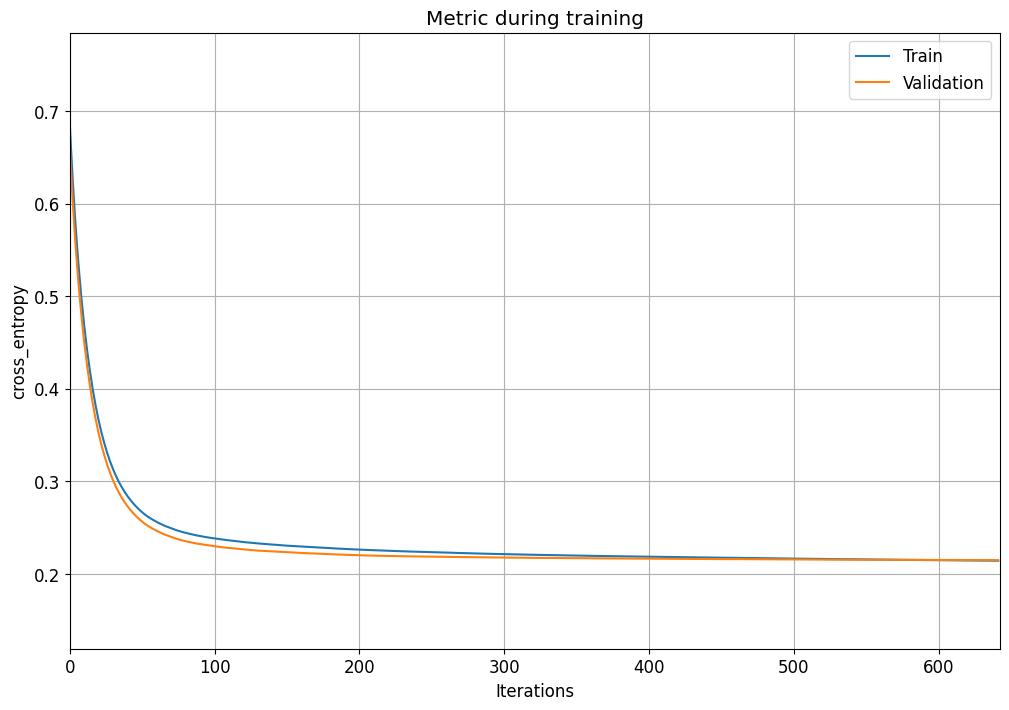

In [34]:
 # Cross-entropy evolution during training
lgb.plot_metric(model_pickle, figsize=(12,8))
plt.title('Metric during training')
plt.savefig(savedir+'AddEvtmu_metric_lr_0.09_35.pdf')

# Quelles caractéristiques ont le plus grand impact sur les prédictions du modèle.

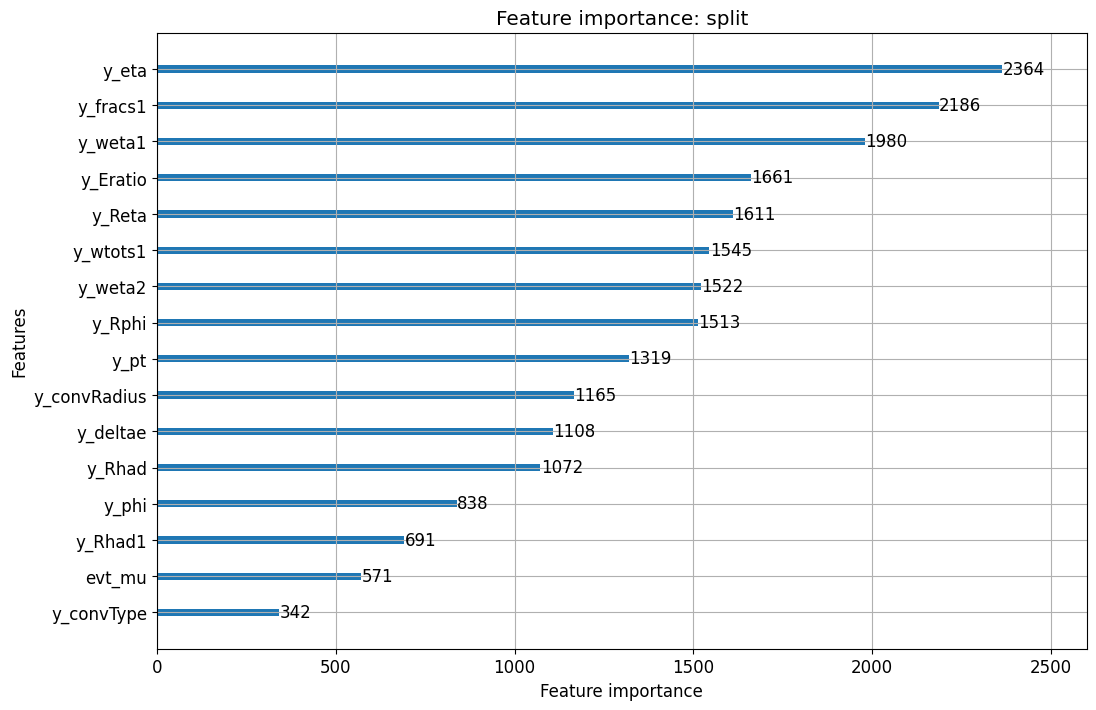

In [35]:
 # Feature importance: Numbers of times the feature is used in a model
lgb.plot_importance(model_pickle, importance_type='split', figsize=(12,8))
plt.title('Feature importance: split')
plt.savefig(savedir+'AddEvtmu_feature_split_lr_0.09_35.pdf')
plt.show()

# Perspective sur la quantité d'information apportée par chaque caractéristique dans la réduction de l'incertitude ou de l'entropie.

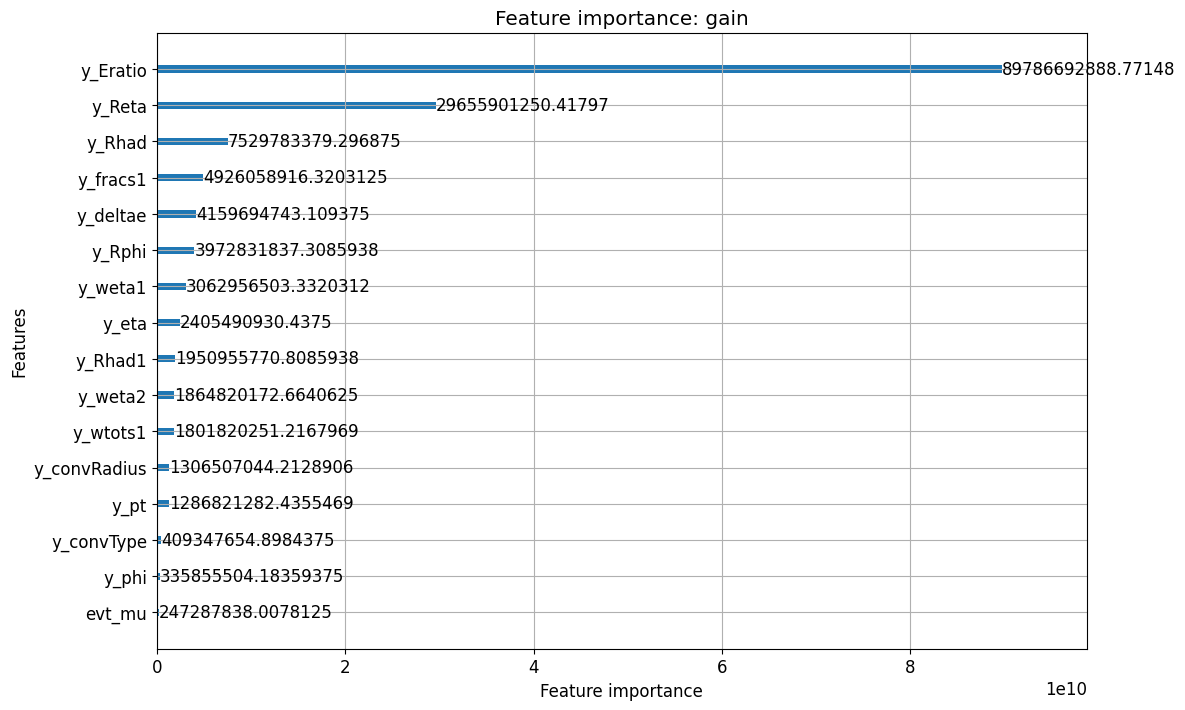

In [36]:
 lgb.plot_importance(model_pickle, importance_type='gain', precision = None, figsize=(12,8))
plt.title('Feature importance: gain')
plt.savefig(savedir+'AddEvtmu_feature_gain_lr_0.09_35.pdf')
plt.show()

In [ ]:
 # make predictions to the test sample
y_pred_prob = model_pickle.predict_proba(x_test)
y_pred_prob_train = model_pickle.predict_proba(x_train)

In [ ]:
y_pred_prob

In [ ]:
y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

In [ ]:
wdf_test.head()

In [ ]:
df = pd.DataFrame(y_pred_prob, columns=['0', '1']) # test sample predictions
dg = pd.DataFrame(y_pred_prob_train, columns = ['0', '1'])

df.reset_index(inplace=True, drop=True)
dg.reset_index(inplace=True, drop=True)

y_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

wdf_test.reset_index(inplace=True, drop=True)
wdf_train.reset_index(inplace=True, drop=True)

In [ ]:
df.head()

# Fusion et Préparation des Données pour les Visualisations

In [ ]:
# join='inner' garantit que seules les lignes avec des indices correspondants dans tous les DataFrames sont conservées.

df2 = pd.concat([df, y_test, wdf_test], axis=1, join='inner', ignore_index=True)
dg2 = pd.concat([dg, y_train, wdf_train], axis=1, join='inner', ignore_index=True)

In [ ]:
df2.head()

In [ ]:
col_names = ["background_score", "signal_score"] + list(y_test.columns) + list(wdf_test.columns)
df2.columns = col_names
dg2.columns = col_names

In [ ]:
xf2 = x_test[kinem_var + conv_var]
xf2.reset_index(inplace=True, drop=True)
df_test_all = pd.concat([xf2,df2], axis=1, join='inner', ignore_index=True)
df_test_all.columns = list(xf2.columns)+list(df2.columns)
df_test_all

# BDT output
The BDT output has two columns: for each event a score (probability) to belong to class 0 or class 1  (here they are called background_class and signal_class ) is assigned.

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

plt.hist(df2[(df2["truth_label"]==0 )]["signal_score"],
         weights = df2[(df2["truth_label"]==0 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5, 
         histtype = 'stepfilled', label='Background', color = 'b')

plt.hist(df2[(df2["truth_label"]==1 )]["signal_score"],
         weights = df2[(df2["truth_label"]==1 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5,
         histtype = 'stepfilled', label='Signal', color = 'orange')

plt.ylabel('Frequency', fontsize = 14)

plt.legend(loc='upper center', fontsize = 14)
plt.gca().set(xlabel="LightGBM score (probability to be assigned to the signal class)")

plt.savefig(savedir+'AddEvtmu_score_lr_0.09_35.pdf')
plt.show()

# ROC curve

compute signal and background efficiencies for "official" cut-based Tight selection

Courbe ROC (Receiver Operating Characteristic) est tracée pour évaluer la performance du modèle. 

En plus, la performance d'une méthode de classification basée sur des seuils fixes ("Cut-based Tight ID") est ajoutée au graphique pour comparaison. La courbe ROC évalue l'efficacité de détection du signal par rapport à l'efficacité du fond, fournissant une mesure visuelle de la qualité du classificateur.

In [ ]:
s_tot = sum( df2[(df2["truth_label"] == 1)]["weight"] )
s_selected = sum( df2[(df2["truth_label"] == 1) & (df2['y_IsTight'].values)]["weight"] )
s_eff = s_selected / s_tot

b_tot = sum( df2[(df2["truth_label"] == 0)]["weight"] )
b_selected = sum( df2[(df2["truth_label"] == 0) & (df2['y_IsTight'].values)]["weight"] )
b_eff = b_selected / b_tot

In [ ]:
print(f"Number of signal events                   = {s_tot:12.0f}")
print(f"Number of signal events passing Tight     = {s_selected:12.0f}")
print(f"Signal efficiency of cut-based Tight      = {100.*s_selected/s_tot:11.2f}%" )
print()
print(f"Number of background events               = {b_tot:12.0f}")
print(f"Number of background events passing Tight = {b_selected:12.0f}")
print(f"Background efficiency of cut-based Tight  = {100.*b_selected/b_tot:11.2f}%" )
print(f"Background rejection of cut-based Tight   = {100.*(1-b_selected/b_tot):11.2f}%" )

Plot ROC curve of trained BDT with weighted events, compare to current cut-based Tight selection

In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Prédire les probabilités pour la classe positive
y_scores = model_pickle.predict_proba(x_test)[:, 1]

# Calculer les taux de faux positifs et vrais positifs ainsi que les seuils
fpr, tpr, thresholds = roc_curve(y_test, y_scores, sample_weight=df2["weight"])

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.plot(b_eff, s_eff, marker="x", markersize=10, color="red", label = 'Cut-based Tight ID')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(savedir+'AddEvtmu_ROC_lr_0.05_35_weight.pdf')

plt.show()


Rôle de la ligne diagonale dans un graphique ROC

    Point de Référence : La ligne diagonale dans un graphique ROC représente un classificateur aléatoire. Un classificateur aléatoire n'a aucune capacité de discrimination et attribue les classes (positives ou négatives) de manière aléatoire, sans aucune corrélation avec les vraies étiquettes.

    Comparaison : Cette ligne sert de point de référence pour évaluer la performance des autres classificateurs. Tout classificateur qui se trouve au-dessus de cette ligne a une performance meilleure que le hasard.

# Correlation between input variables

In [ ]:
#x_train_sel = x_train.query('y_wtots1 >- 800 & y_weta1 > -800')
#x_train_sel.reset_index(inplace=True, drop=True)

In [ ]:
corr = x_train.corr()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,13))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
plt.savefig(savedir+'AddEvtmu_correlations_train_sample_all.pdf')
plt.show()

# Check correlation of discriminating variables (shower shapes) 

Separately for signal (true photons) and background (fake photons from jets)

In [ ]:
corr_sig = x_train[(y_train==1)].corr()

In [ ]:
corr_bkg = x_train[(y_train==0)].corr()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,13))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr_sig, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
plt.savefig(savedir+'AddEvtmu_correlations_train_sample_all.pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,13))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr_bkg, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
plt.savefig(savedir+'AddEvtmu_correlations_train_sample_all.pdf')
plt.show()